In [88]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *

### Taming for Langevin Algorithms

We consider the problem of sampling from a probability measure $ \pi $ having a density on $ \mathbb{R}^d $ known up to a normalizing constant, $ x \mapsto e^{-U(x)}/\int_{\mathbb{R}^d} e^{-U(y)} dy $

The Euler discretization of the Langevin stochastic differential equation (SDE) is known to be unstable in a precise sense, when the potential $U$ is superlinear, i.e. $ \liminf_{\|x\| \to +\infty} \frac{\|\nabla U(x)\|}{\|x\|} = +\infty $. 

In that case, the second order moment of the process $lim_{+\infty} \mathbb{E}[X_n^{2}] = +\infty$ and the sample path $(X_n)_n$ diverges to infinity with a positive probability. This is why we introduce new schemes such as Taming to address this problem. 


------------------------------------------------------------------------------------------------------------------------------------------------------
First example, we consider the following target distribution, called the double well : 

$ \pi(x) = \frac{e^{-U(x)}}{\int_{\mathbb{R}^d} e^{-U(y)} \, dy} \space \propto \space  e^{-U(x)} $ 

We know the target distribution up the normalizing constant and the potential function here is : 

$U(x) = \frac{1}{4} \left\| x \right\|^4 - \frac{1}{2} \left\| x \right\|^2  $

So the potential here is superlinear. We are going to verify that the ULA diverges with a positive probability in this case. 


In [4]:
def grad_double_well(x) : 

    alpha = np.linalg.norm(x, axis = 1) ** 2 - 1

    return alpha[:, np.newaxis] * x

In [148]:
def plot_density_DW(plot_sample = None): 

    x_axis = np.linspace(-5, 5, 200)
    y_axis = np.linspace(-5, 5, 200)

    xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)

    pos = np.dstack((xx_axis, yy_axis))
    
    # Compute the pdf 

    norm = np.linalg.norm(pos, axis = 2)

    pdf = np.exp(-((1/4) * (norm ** 4) - (1/2) * (norm ** 2)))
    
    # Plot the result

    plt.figure(figsize=(8, 8))
    plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.4) 
    ## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
    plt.colorbar()
    
    if plot_sample is not None:
        x = plot_sample[:, 0]
        y = plot_sample[:, 1]
        plt.scatter(x, y, alpha=0.5, s = 8, color = 'red')

    plt.title('Double Well density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

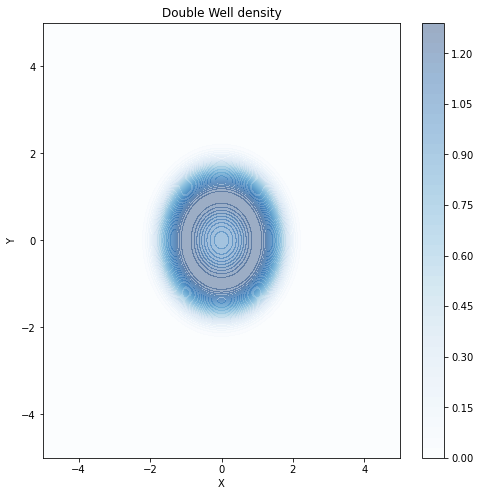

In [149]:
plot_density_DW()

In [7]:
def ULA_double_well(x_init, nb_iter, step) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(x.shape[0])

    gradient_term = np.zeros(x.shape[0])

    for i in tqdm(range(nb_iter)):

        # Each iteration we compute the gradient of the target distribution and update the position of the particles
        grad = grad_double_well(x)

        noise =  np.sqrt(2 * step) * np.random.randn(dim_sample, dim_var)

        stochastic_term += np.linalg.norm(noise, axis = 1)

        gradient_term += np.linalg.norm(step * grad, axis = 1) #Size of this vector is nb_particles

        x = x - step * grad + noise

    plot_density_DW(x)

    return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


    

We introduce the tamed step size to prevent the process from diverging. In the case of the double-well density, we can tame only the superlinear part of the density : 
$G_\gamma(x) = \frac{\|x\|^2 x - x}{1 + \gamma \|x\|^2}$

With this version it seems that it doesn't work so we use the classic formule for the taming coefficients

In [8]:
def ULA_double_well_tamed(x_init, nb_iter, step) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(dim_sample)

    gradient_term = np.zeros(dim_sample)

    for i in tqdm(range(nb_iter)):


        ## Version with proposed taming scheme in the paper -> taming only the superlinear part of the gradient
        #norm_sample_squared = np.linalg.norm(x, axis = 1) ** 2
        #tamed_coef = (norm_sample_squared[:, np.newaxis] * x) * (step / (1 + step * norm_sample_squared ** (3/2)))[:, np.newaxis] - x ## Après recalcul, quand on prend la norme du gradient de la partie superlinear c'est plus la norme au cube plutôt qu'au carré..... A verifier
        #tamed_coef = (norm_sample_squared[:, np.newaxis] * x) * (step / (1 + step * norm_sample_squared))[:, np.newaxis] - x

        # Version with classic taming scheme
        grad = grad_double_well(x)
        grad_norm = np.linalg.norm(grad, axis = 1)
        tamed_coef = grad * (step / (1 + step * grad_norm))[:, np.newaxis]
        

        noise =  np.sqrt(2 * step) * np.random.randn(dim_sample, dim_var)

        stochastic_term += np.linalg.norm(noise, axis = 1)

        gradient_term += np.linalg.norm(tamed_coef, axis = 1) #Size of this vector is nb_particles

        x = x - tamed_coef + noise #warning : the sign of the gradient

    plot_density_DW(x)

    return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


    

In [159]:
def ULA_double_well_adapt(x_init, nb_iter, alpha = 0.01) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(nb_iter)

    gradient_term = np.zeros(nb_iter)

    grad_nor_ev = np.zeros(nb_iter)

    step_tab = np.zeros(dim_sample)

    x_traj = np.zeros((nb_iter, dim_var))

    time_mean = np.zeros(nb_iter)

    time = np.zeros(dim_sample)

    step_tab_tab = np.zeros(nb_iter)

    for i in tqdm(range(nb_iter)):


        ## Version with proposed taming scheme in the paper -> taming only the superlinear part of the gradient
        #norm_sample_squared = np.linalg.norm(x, axis = 1) ** 2
        #tamed_coef = (norm_sample_squared[:, np.newaxis] * x) * (step / (1 + step * norm_sample_squared ** (3/2)))[:, np.newaxis] - x ## Après recalcul, quand on prend la norme du gradient de la partie superlinear c'est plus la norme au cube plutôt qu'au carré..... A verifier
        #tamed_coef = (norm_sample_squared[:, np.newaxis] * x) * (step / (1 + step * norm_sample_squared))[:, np.newaxis] - x

        # Version with classic taming scheme
        grad = grad_double_well(x)
        grad_norm = np.linalg.norm(grad, axis = 1)

        grad_nor_ev[i] = np.nanmean(grad_norm)

        step_tab = np.minimum(1 / (1e-10 + grad_norm), 100) * alpha 
        step_tab_tab[i] = np.nanmean(step_tab)

        time += step_tab    

        time_mean[i] = np.nanmean(time)

        grad_update = grad * step_tab[:, np.newaxis]

        noise =  np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(dim_sample, dim_var)
        #noise =  np.sqrt(2 * alpha) * np.random.randn(dim_sample, dim_var)
        
        stochastic_term[i] = np.nanmean(np.linalg.norm(noise, axis = 1))

        gradient_term[i] = np.nanmean(np.linalg.norm(grad_update, axis = 1)) #Size of this vector is nb_particles

        x = x - grad_update + noise #warning : the sign of the gradient
            
    plot_density_DW(x)

    #return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'
    return stochastic_term, gradient_term, time_mean, grad_nor_ev, step_tab_tab

    

In [161]:
sample_init = np.random.randn(1000, 2)

In [165]:
#We define the grid

x = np.linspace(-15, 15, 4)
y = np.linspace(-15, 15, 4)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances = np.array([[[3, 0], [0, 3]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

### ULA is Unstable if the potential has a superlinear drift

For different step sizes, we study the behaviour of both approaches : 

- Step size varying between 0.001 and 0.2

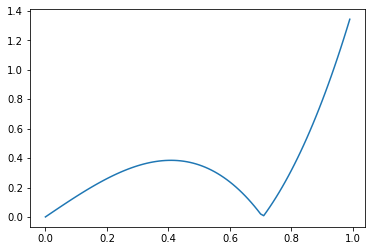

In [164]:
x = np.zeros((100, 2, 2))
y = np.zeros(100)
for i in range(100):
    x[i] = grad_double_well(np.array([[i/100, i/100], [i/100, i/100]]))
    y[i] = np.linalg.norm(x[i], axis = 1)[0]
plt.plot(np.arange(100) / 100, y)


This is the plot for classic ULA : 


100%|██████████| 10000/10000 [00:02<00:00, 3527.01it/s]


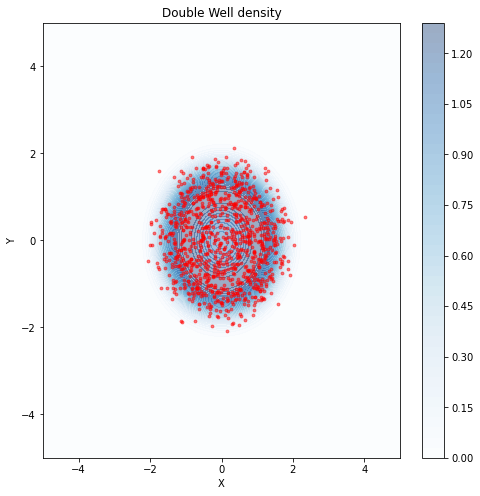

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:04<00:00, 2049.56it/s]


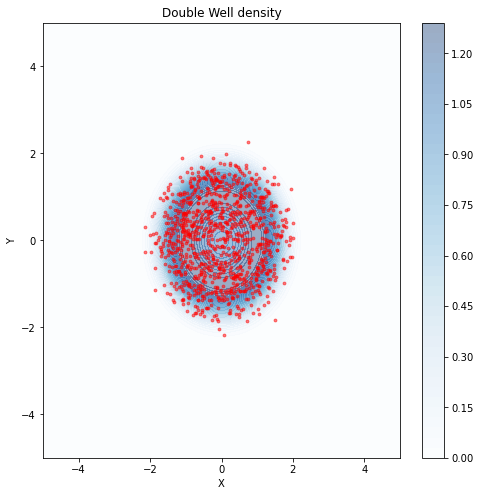

This is the plot for ULA with adaptive step size : 


100%|██████████| 10000/10000 [00:10<00:00, 950.10it/s]


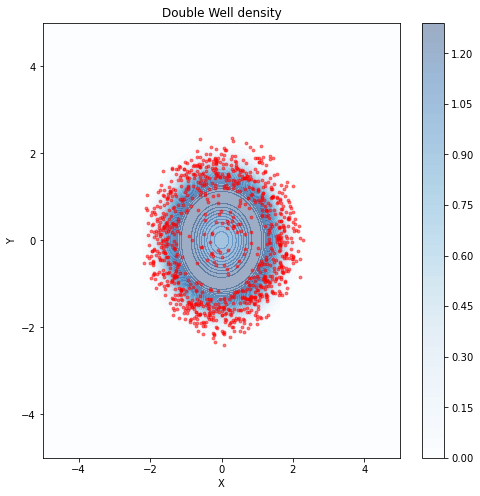

(array([0.08166547, 0.0810167 , 0.07452859, ..., 0.04090948, 0.03973749,
        0.03963332]),
 array([0.00099876, 0.00099871, 0.00099889, ..., 0.001     , 0.001     ,
        0.001     ]),
 array([3.80191657e-03, 6.97685993e-03, 9.99852404e-03, ...,
        8.01225917e+00, 8.01295416e+00, 8.01362462e+00]),
 array([2.48528922, 2.51642109, 2.53053643, ..., 3.4599774 , 3.45704585,
        3.44986722]),
 array([0.00380192, 0.00317494, 0.00302166, ..., 0.00070597, 0.000695  ,
        0.00067045]))

In [167]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.001)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.001)
print('This is the plot for ULA with adaptive step size : ')
ULA_double_well_adapt(sample_init, 10000, 0.001)

This is the plot for classic ULA : 


100%|██████████| 10000/10000 [00:04<00:00, 2488.39it/s]


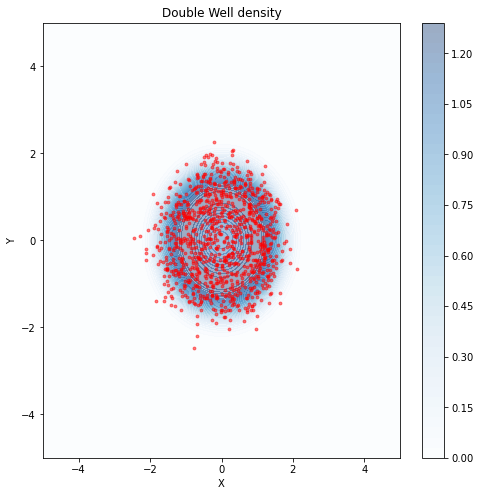

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:04<00:00, 2107.81it/s]


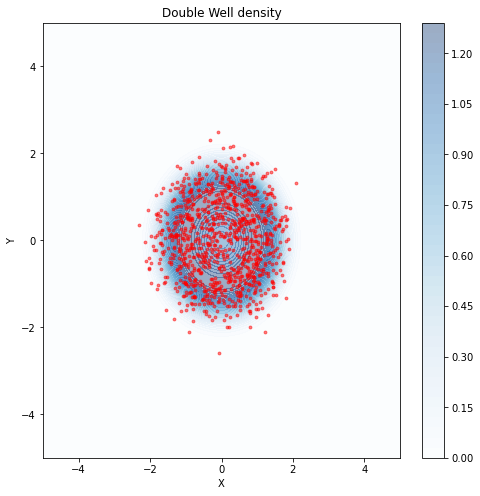

This is the plot for ULA with adaptive step size : 


100%|██████████| 10000/10000 [00:05<00:00, 1712.35it/s]


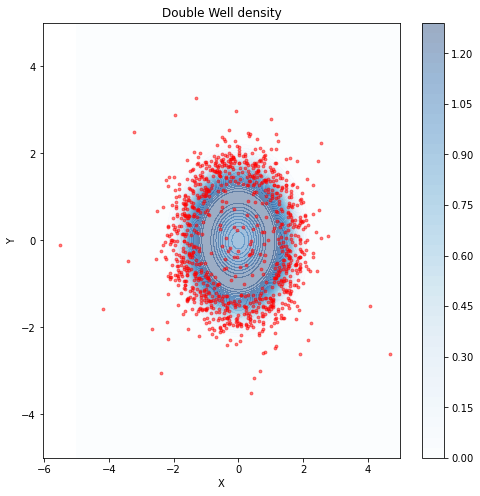

'The magnitude of the Stochastic term is 0.11902016668568342 whereas the magnitude of the gradient term is 0.009995416818310622'

In [14]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.01)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.01)
print('This is the plot for ULA with adaptive step size : ')
ULA_double_well_adapt(sample_init, 10000, 0.01)

This is the plot for classic ULA : 


  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_65316/725825739.py:5: RuntimeWarning: overflow encountered in multiply
  return alpha[:, np.newaxis] * x
/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_65316/2091928910.py:24: RuntimeWarning: invalid value encountered in subtract
  x = x - step * grad + noise
100%|██████████| 10000/10000 [00:02<00:00, 3333.51it/s]


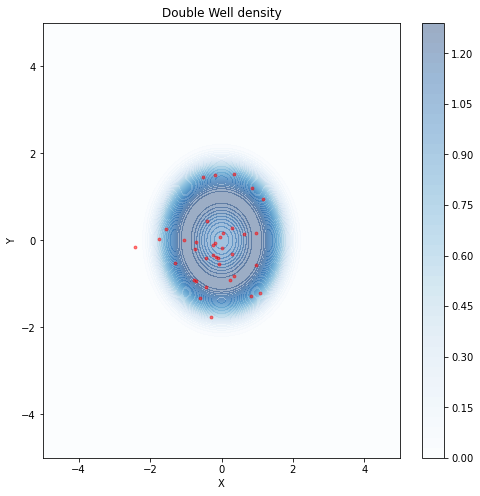

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:03<00:00, 2777.51it/s]


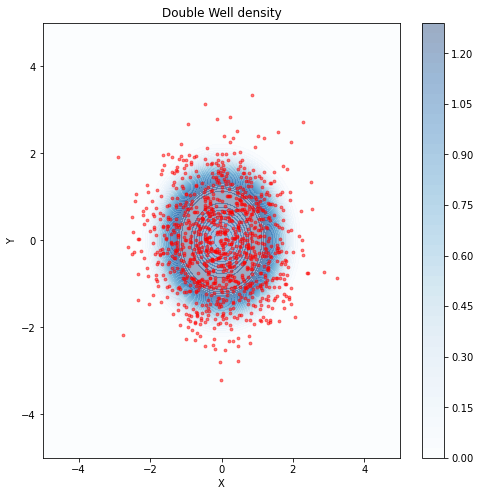

This is the plot for ULA with adaptive step size : 


100%|██████████| 10000/10000 [00:02<00:00, 3497.01it/s]


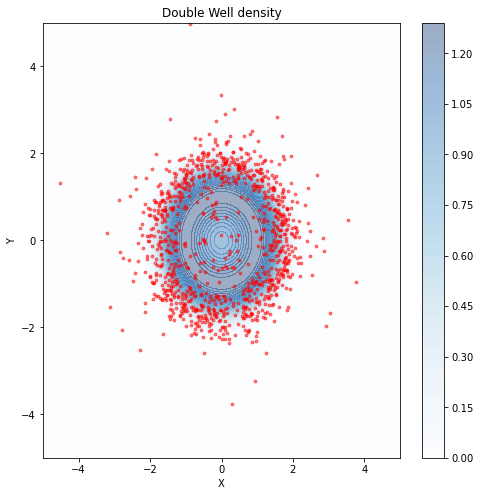

'The magnitude of the Stochastic term is 0.11890767256440532 whereas the magnitude of the gradient term is 0.009995540930756852'

In [15]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.2)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.2)
print('This is the plot for ULA with adaptive step size : ')
ULA_double_well_adapt(sample_init, 10000, 0.2)

This is the plot for classic ULA : 


  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_65316/725825739.py:5: RuntimeWarning: overflow encountered in multiply
  return alpha[:, np.newaxis] * x
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_65316/2091928910.py:24: RuntimeWarning: invalid value encountered in subtract
  x = x - step * grad + noise
100%|██████████| 10000/10000 [00:02<00:00, 3632.55it/s]


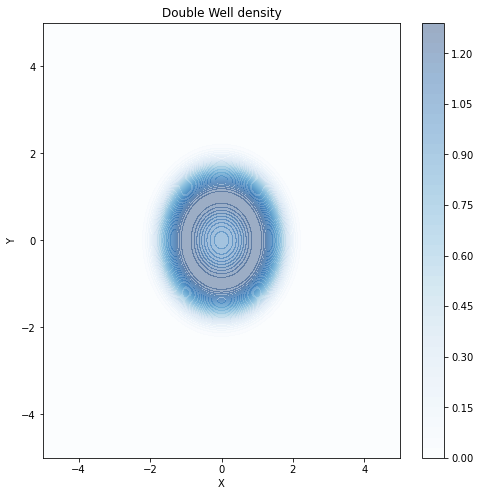

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_65316/2091928910.py:28: RuntimeWarning: Mean of empty slice
  return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:02<00:00, 3945.03it/s]


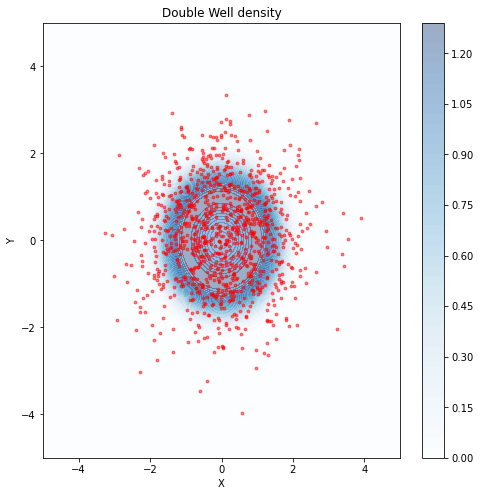

This is the plot for ULA with adaptive step size : 


100%|██████████| 10000/10000 [00:03<00:00, 3228.79it/s]


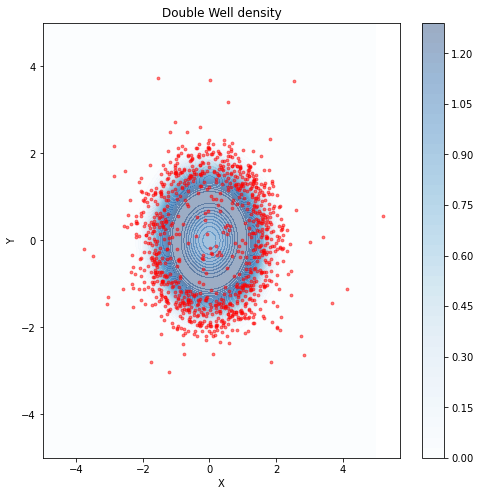

'The magnitude of the Stochastic term is 0.11930210712854826 whereas the magnitude of the gradient term is 0.009995473067197594'

In [16]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.3)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.3)
print('This is the plot for ULA with adaptive step size : ')
ULA_double_well_adapt(sample_init, 10000, 0.3)

BROUILLON